In [220]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score, f1_score, accuracy_score, classification_report

In [221]:
obesity = pd.read_csv('ObesityPrediction.csv')
obesity.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,NaN,NaN,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,NaN,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,NaN,Normal_Weight
3,Male,27.0,NaN,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [222]:
obesity.isna().sum()

Gender            123
Age               114
Height            101
Weight            119
family_history    110
FAVC               99
FCVC               88
NCP               125
CAEC              115
SMOKE             103
CH2O              102
SCC               118
FAF               102
TUE               129
CALC              127
MTRANS             96
Obesity             0
dtype: int64

**Mapping Target column with relevant values**

In [223]:
# Mapping 'Obesity' Column to 1-Overweight and 0-Normalweight
obesity['Obesity'] = obesity['Obesity'].map({'Normal_Weight':0, 'Overweight_Level_I':1, 'Overweight_Level_II':2, 'Obesity_Type_I':3, 
                                             'Insufficient_Weight':4, 'Obesity_Type_II':5, 'Obesity_Type_III':6})

**Separating categorical and numerica columns**

In [224]:
category_features = [col for col in obesity.columns if obesity[col].dropna().apply(lambda x: isinstance(x, str)).all()]
numeric_features = [col for col in obesity.columns if obesity[col].dropna().apply(lambda x: isinstance(x, (int, float))).all()]

**Filling Missing Values with SimpleImputer**

In [225]:
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='mean')
oneHot = OneHotEncoder()

In [226]:
fill = ColumnTransformer([('categorical_filling', cat_imputer, category_features),
                                ('numerical_filling', num_imputer, numeric_features)],
                               remainder='passthrough')
filled_value = fill.fit_transform(obesity)

**Creating DataFrame out of filled values**

In [227]:
filled_df = pd.DataFrame(filled_value, columns=category_features+numeric_features).round(2)

**Making column appearance or order accoring to the original column patterns**

In [228]:
obesity_df = filled_df[obesity.columns]
obesity_df.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,1.003953,0.653087,no,Public_Transportation,0.0
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,0.0
2,Male,23.0,1.8,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,0.0
3,Male,27.0,1.702195,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,1.0
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,2.0


**Splitting x and y value**

In [229]:
X = obesity_df.drop(columns=['Obesity'])
y = obesity_df.Obesity.astype(int)

**Category Transform: Changing string value to numeric values**

In [230]:
transformer = ColumnTransformer([('cat_conversion', oneHot, category_features)],
                                remainder = 'passthrough')
transformed_data = transformer.fit_transform(X)

In [231]:
# Skimming floating values to 2-decimal places
transformed_x = pd.DataFrame(transformed_data).map(lambda col: round(col, 2) if isinstance(col, (int, float)) else col)

In [232]:
transformed_x.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,21.0,1.62,64.0,2.0,3.0,2.0,1.0,0.65
1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,21.0,1.52,56.0,3.0,3.0,3.0,3.0,0.00
2,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,23.0,1.80,77.0,2.0,3.0,2.0,2.0,1.00
3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,27.0,1.70,87.0,3.0,3.0,2.0,2.0,0.00
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,22.0,1.78,89.8,2.0,1.0,2.0,0.0,0.00


**Splitting train and test data**

In [233]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(transformed_x, y, test_size=0.2)

## Normalizing Data and ML Models that require normalization

**`LinearRegression, LogisticRegression, SVM, K-NearestNeighbors` require normalized data**

In [234]:
scaler = StandardScaler()
X_trains = scaler.fit_transform(X_train)
X_tests = scaler.transform(X_test)

**1. `LogisticRegression`**

In [235]:
log_reg = LogisticRegression()
log_reg.fit(X_trains, y_train)
round(log_reg.score(X_tests, y_test), 3)*100

79.7

In [236]:
y_log_pred = log_reg.predict(X_tests)

**2. `Support Vector Mechanism (SVM)`**

In [237]:
svm = SVC()
svm.fit(X_trains, y_train)
round(svm.score(X_tests, y_test), 3)*100

78.5

In [238]:
y_svm_pred = svm.predict(X_tests)

**3. `K-Nearest Neighbors (KNN)`**

In [239]:
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_trains, y_train)
round(knn.score(X_tests, y_test), 3)*100

76.1

In [240]:
y_knn_pred = knn.predict(X_tests)

**4. `Principal Component Analysis (PCA)`**
* PCA is used for dimensionality reduction (higher dimension data to lower)
* PCA is similar to StandardScaler(), but it changes the dimensions
* If we have 20 columns, using PCA, columns can be reduced to `n_components=n` number of dimensions

In [241]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(transformed_x)

In [242]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [243]:
#Splitting Data in training and testing sets
np.random.seed(42)
X_train_I, X_test_I, y_train_I, y_test_I = train_test_split(X_pca, y, test_size=0.2)

In [244]:
# Using ML model on training and testing sets
clf = LogisticRegression()
clf.fit(X_train_I, y_train_I)
round(clf.score(X_test_I, y_test_I), 2)*100

48.0

## ML models that do not require normalization

**1. Gradient Boosted Frameworks**
* `XGBClassifier`

In [245]:
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
xgb_clf.fit(X_train, y_train)
round(xgb_clf.score(X_test, y_test), 3)*100

92.0

In [246]:
y_xgb_pred = xgb_clf.predict(X_test)

* `LGBMClassifier`

In [247]:
lgbm_clf = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, verbose=-1)
lgbm_clf.fit(X_train, y_train)
round(lgbm_clf.score(X_test, y_test), 3)*100

92.2

In [248]:
y_lgbm_pred = lgbm_clf.predict(X_test)

* `CatBoostClassifier`

In [249]:
catboost_clf = CatBoostClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, verbose=0, random_state=42)
catboost_clf.fit(X_train, y_train)
round(catboost_clf.score(X_test, y_test), 3)*100

83.2

In [250]:
y_cat_pred = catboost_clf.predict(X_test)

**2. `GradientBoostingClassifier`**

In [251]:
grad_clf = GradientBoostingClassifier(n_estimators=150, learning_rate=0.3, max_depth=3, random_state=42)
grad_clf.fit(X_train, y_train)
round(grad_clf.score(X_test, y_test), 3)*100

92.7

In [252]:
y_gradient_pred = grad_clf.predict(X_test)

**3. `RandomForestClassifier`**

In [253]:
rand_clf = RandomForestClassifier()
rand_clf.fit(X_train, y_train)
round(rand_clf.score(X_test, y_test), 3)*100

91.3

In [254]:
y_rand_pred = rand_clf.predict(X_test)

## Creating Dictionary out of all Machine Learning Models

**Creating Function for all kind of scores**

In [255]:
def model_evaluation(y_test, y_pred):
    print(f'AccuracyScor: {accuracy_score(y_test, y_pred):.3f}'),
    print(f'PrecisionScore: {precision_score(y_test, y_pred, average='weighted'):.3f}'),
    print(f'RecallScore: {recall_score(y_test, y_pred, average='weighted'):.3f}'),
    print(f'F1Score: {f1_score(y_test, y_pred, average='weighted'):.3f}')
    print('\n')
    
    metrics = {'AccuracyScore': accuracy_score(y_test, y_pred),
               'PrecisionScore': precision_score(y_test, y_pred, average='weighted'),
               'RecallScore': recall_score(y_test, y_pred, average='weighted'),
               'F1Score': f1_score(y_test, y_pred, average='micro')
              }
    return metrics

In [256]:
ml_models = {
    'LogisticRegression': model_evaluation(y_test, y_log_pred),
    'SupportVectorMechanism': model_evaluation(y_test, y_svm_pred),
    'K-NearestNeighbors': model_evaluation(y_test, y_knn_pred),
    'XGBClassifier': model_evaluation(y_test, y_xgb_pred),
    'LGBMClassifier': model_evaluation(y_test, y_lgbm_pred),
    'CatBoostClassifier': model_evaluation(y_test, y_cat_pred),
    'GradientBoostingClassifier': model_evaluation(y_test, y_gradient_pred),
    'RandomForestClassifier': model_evaluation(y_test, y_rand_pred)
}

AccuracyScor: 0.797
PrecisionScore: 0.808
RecallScore: 0.797
F1Score: 0.790


AccuracyScor: 0.785
PrecisionScore: 0.783
RecallScore: 0.785
F1Score: 0.783


AccuracyScor: 0.761
PrecisionScore: 0.759
RecallScore: 0.761
F1Score: 0.758


AccuracyScor: 0.920
PrecisionScore: 0.921
RecallScore: 0.920
F1Score: 0.919


AccuracyScor: 0.922
PrecisionScore: 0.923
RecallScore: 0.922
F1Score: 0.921


AccuracyScor: 0.832
PrecisionScore: 0.837
RecallScore: 0.832
F1Score: 0.831


AccuracyScor: 0.927
PrecisionScore: 0.928
RecallScore: 0.927
F1Score: 0.927


AccuracyScor: 0.913
PrecisionScore: 0.915
RecallScore: 0.913
F1Score: 0.913




In [257]:
model_df = pd.DataFrame.from_dict(ml_models, orient='index')

In [258]:
model_df

,AccuracyScore,PrecisionScore,RecallScore,F1Score
LogisticRegression,0.796690,0.807941,0.796690,0.796690
SupportVectorMechanism,0.784870,0.782731,0.784870,0.784870
K-NearestNeighbors,0.761229,0.759423,0.761229,0.761229
XGBClassifier,0.919622,0.921266,0.919622,0.919622
LGBMClassifier,0.921986,0.922715,0.921986,0.921986
CatBoostClassifier,0.832151,0.837120,0.832151,0.832151
GradientBoostingClassifier,0.926714,0.928292,0.926714,0.926714
RandomForestClassifier,0.912530,0.914579,0.912530,0.912530


<Axes: >

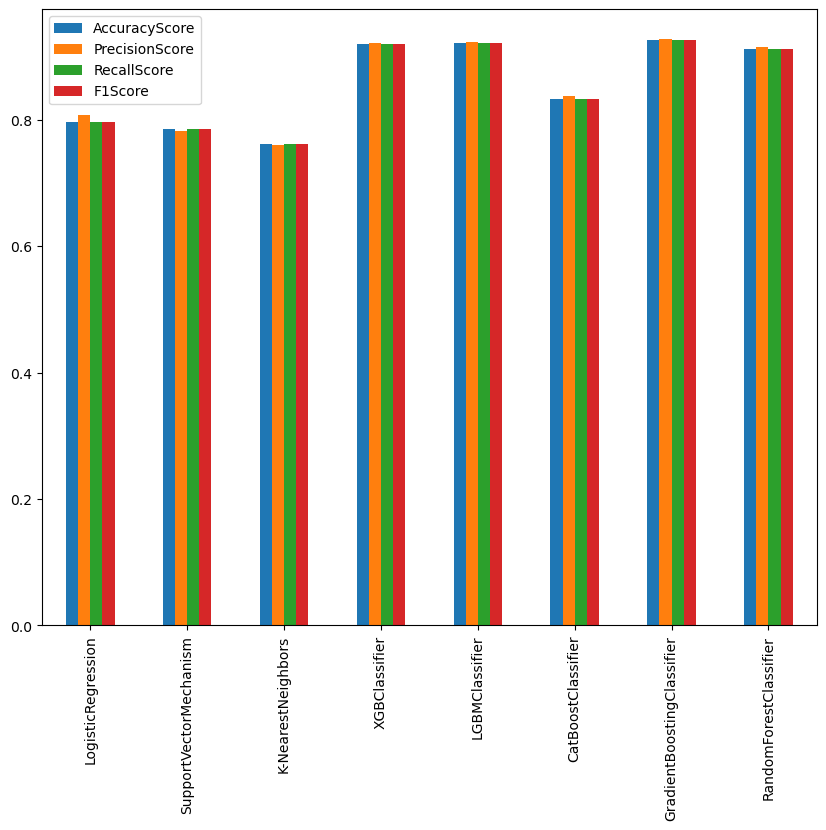

In [259]:
model_df.plot(kind='bar', figsize=(10,8))

In [260]:
models_long = model_df.reset_index().melt(id_vars='index', var_name='Metrics', value_name='Score')
models_long.rename(columns={'index':'Models'}, inplace=True)

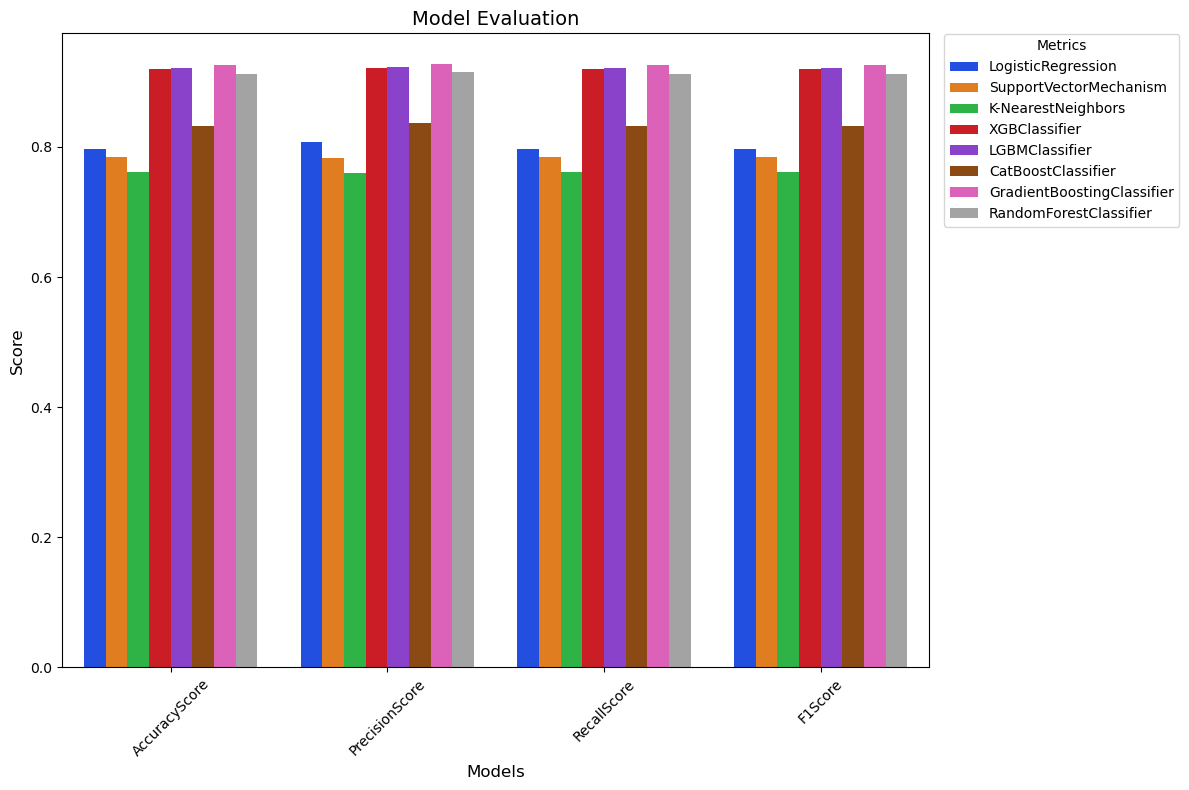

In [261]:
plt.figure(figsize=(12, 8))
sns.barplot(data=models_long, x='Metrics', y='Score', hue='Models', palette='bright')
plt.title('Model Evaluation', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Metrics', fontsize=10, bbox_to_anchor = (1.01, 1.01))
plt.tight_layout()
plt.show();

## Cross Validation

In [262]:
x = transformed_x
y = obesity_df.Obesity

In [267]:
models_val = [log_reg, svm, knn, xgb_clf, lgbm_clf, catboost_clf, grad_clf, rand_clf]
score_list = ['accuracy', 'precision', 'recall', 'f1']
results = {}
for mod in models_val:
    model_name = mod.__class__.__name__
    results[model_name]= {}
    for metric in score_list:
        score = cross_val_score(estimator=mod, X=x, y=y, cv=5, scoring=metric).mean()
        results[model_name][metric] = score

for model, metrics in results.items():
    print(f'\n{model}: ')
    for metric, score in metrics.items():
        print(f'{metric}: {score:.3f}')

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nareshdhami/Desktop/MachineLearning/env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nareshdhami/Desktop/MachineLearning/env/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nareshdhami/Desktop/MachineLearning/env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py", line 1231, in fit
    check_classification_targets(y)
  File "/Users/nareshdhami/Desktop/MachineLearning/env/lib/python3.12/site-packages/sklearn/utils/multiclass.py", line 219, in check_classification_targets
    raise ValueError(
ValueError: Unknown label type: unknown. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.
